<a href="https://colab.research.google.com/github/eterniacockers/BASH-Risk/blob/main/Fuzzy_AHP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd

# Upload file
uploaded = files.upload()

Saving AHP Matrix.xlsx to AHP Matrix.xlsx


In [ ]:
import pandas as pd

# Load pairwise matrix from Excel
file_path = "AHP Matrix.xlsx"  # Make sure filename matches exactly
df = pd.read_excel(file_path, index_col=0)  # Assuming first column is labels
pairwise_matrix = df.values  # Convert to NumPy array


In [ ]:
import numpy as np
import pandas as pd

# Step 1: Define Triangular Fuzzy Numbers (TFNs) for Saaty's 1-9 scale
fuzzy_scale = {
    1: (1, 1, 1),
    2: (1, 2, 3),
    3: (2, 3, 4),
    4: (3, 4, 5),
    5: (4, 5, 6),
    6: (5, 6, 7),
    7: (6, 7, 8),
    8: (7, 8, 9),
    9: (9, 9, 9)
}

# Step 2: Create a fuzzy pairwise comparison matrix
def create_fuzzy_matrix(pairwise_matrix):
    n = pairwise_matrix.shape[0]
    fuzzy_matrix = [[(0,0,0) for _ in range(n)] for _ in range(n)]

    for i in range(n):
        for j in range(n):
            val = pairwise_matrix[i, j]
            if val == 0:
                fuzzy_matrix[i][j] = (0, 0, 0)
            elif val >= 1:  # Direct judgment
                rounded_val = int(round(val))
                rounded_val = min(max(rounded_val, 1), 9)
                fuzzy_matrix[i][j] = fuzzy_scale[rounded_val]
            else:  # Reciprocal judgment
                estimated_score = 10 - (val * 9)
                rounded_score = int(round(estimated_score))
                rounded_score = min(max(rounded_score, 1), 9)
                l, m, u = fuzzy_scale[rounded_score]
                fuzzy_matrix[i][j] = (1/u, 1/m, 1/l)
    return fuzzy_matrix



In [ ]:
# Step 3: Calculate fuzzy synthetic extent
def calculate_fuzzy_synthetic_extent(fuzzy_matrix):
    n = len(fuzzy_matrix)
    S = []

    # Sum columns
    col_sums = [(0,0,0) for _ in range(n)]
    for j in range(n):
        l_sum, m_sum, u_sum = 0, 0, 0
        for i in range(n):
            l, m, u = fuzzy_matrix[i][j]
            l_sum += l
            m_sum += m
            u_sum += u
        col_sums[j] = (l_sum, m_sum, u_sum)

    # Calculate synthetic extent for each row
    for i in range(n):
        l_row, m_row, u_row = 0, 0, 0
        for j in range(n):
            l, m, u = fuzzy_matrix[i][j]
            l_row += l
            m_row += m
            u_row += u
        l_total = sum([col[2] for col in col_sums])  # Sum of upper bounds
        m_total = sum([col[1] for col in col_sums])  # Sum of middle values
        u_total = sum([col[0] for col in col_sums])  # Sum of lower bounds

        S.append((l_row/u_total, m_row/m_total, u_row/l_total))

    return S


In [ ]:
# Step 4: Defuzzify using centroid method
def defuzzify(fuzzy_numbers):
    crisp_values = []
    for (l, m, u) in fuzzy_numbers:
        crisp = (l + m + u) / 3
        crisp_values.append(crisp)
    return crisp_values

In [ ]:
## Step 5: Normalize the defuzzified weights
def normalize_weights(crisp_values):
    total = sum(crisp_values)
    normalized = [val / total for val in crisp_values]
    return normalized

In [ ]:
if __name__ == "__main__":
    file_path = "AHP Matrix.xlsx"
    all_sheets = pd.read_excel(file_path, sheet_name=None, index_col=0)

    features = ['Wet_Bulb', 'Altimeter', 'Precipitation', 'Humidity', 'Sky_Cond', 'Visibility', 'Wind_Dir', 'Wind_Speed']
    results = {}

    for sheet_name, df in all_sheets.items():
        print(f"\nProcessing Sheet: {sheet_name}")
        try:
            df = df.dropna(how='all').dropna(axis=1, how='all')

            if df.empty:
                print(f"Sheet {sheet_name} skipped (empty sheet)")
                continue

            # ✅ No iloc slicing!
            # ✅ Reindex properly just like yesterday
            df = df.reindex(index=features, columns=features)

            pairwise_matrix = df.values
            pairwise_matrix = pairwise_matrix.astype(np.float64)

            if pairwise_matrix.shape[0] != pairwise_matrix.shape[1]:
                print(f"Sheet {sheet_name} skipped (matrix not square)")
                continue

            fuzzy_matrix = create_fuzzy_matrix(pairwise_matrix)
            fuzzy_synthetic_extent = calculate_fuzzy_synthetic_extent(fuzzy_matrix)
            crisp_weights = defuzzify(fuzzy_synthetic_extent)
            normalized_weights = normalize_weights(crisp_weights)

            results[sheet_name] = normalized_weights

            print(f"Normalized Weights for {sheet_name}: {normalized_weights}")

        except Exception as e:
            print(f"Error processing sheet {sheet_name}: {e}")

    results_df = pd.DataFrame.from_dict(results, orient='index', columns=features)

    print("\nFinal Aggregated Results:")
    print(results_df)

    results_df.to_csv("Fuzzy_AHP_Results.csv", index=True)

from google.colab import files
files.download('Fuzzy_AHP_Results.csv')




Processing Sheet: 1
Normalized Weights for 1: [0.0643709150776588, 0.023856914678229115, 0.09816707352650969, 0.035090934314896544, 0.16721186787899422, 0.26270053610123084, 0.07421290490538453, 0.2743888535170962]

Processing Sheet: 2
Normalized Weights for 2: [0.0442387074850936, 0.12449931673208674, 0.2902008612280564, 0.07296271486032864, 0.08388902771610439, 0.07206356285077876, 0.1481066189671619, 0.16403919016038956]

Processing Sheet: 3
Normalized Weights for 3: [0.07502656230489248, 0.009055424713281959, 0.18634629042984463, 0.058265146903320485, 0.11462127272678456, 0.19167851648942624, 0.1662982941137954, 0.1987084923186543]

Processing Sheet: 4
Normalized Weights for 4: [0.1069158846924102, 0.03668133785412214, 0.29079137039171404, 0.07496704685780228, 0.2451765132664895, 0.13216335005333255, 0.012740326275763159, 0.10056417060836609]

Processing Sheet: 5
Normalized Weights for 5: [0.018897003193950584, 0.18256597646932907, 0.21216461049422203, 0.05515921826668706, 0.15048

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ Create DataFrame for Fuzzy AHP (already done actually)
priority_df = results_df.copy()
priority_df.columns = features  # (optional, if not already correct)

# ✅ Preview
print(priority_df.round(4))



    Wet_Bulb  Altimeter  Precipitation  Humidity  Sky_Cond  Visibility  \
1     0.0644     0.0239         0.0982    0.0351    0.1672      0.2627   
2     0.0442     0.1245         0.2902    0.0730    0.0839      0.0721   
3     0.0750     0.0091         0.1863    0.0583    0.1146      0.1917   
4     0.1069     0.0367         0.2908    0.0750    0.2452      0.1322   
5     0.0189     0.1826         0.2122    0.0552    0.1505      0.1359   
6     0.1197     0.0220         0.1996    0.0516    0.0881      0.1848   
7     0.0862     0.1146         0.2636    0.0178    0.0693      0.1984   
8     0.1000     0.0444         0.2132    0.0132    0.1196      0.1906   
9     0.0782     0.2305         0.1706    0.0692    0.1581      0.0978   
10    0.2198     0.0272         0.3699    0.0266    0.0316      0.1793   
11    0.0963     0.1099         0.1320    0.0976    0.1661      0.1186   
12    0.0180     0.0542         0.1361    0.0242    0.1395      0.1505   
13    0.0887     0.0242         0.3377

In [ ]:
# ✅ Average feature importance across all respondents
average_weights = priority_df.mean().sort_values(ascending=False)

print("\nAverage Feature Weights (Across All Experts):")
print(average_weights.round(4))




Average Feature Weights (Across All Experts):
Precipitation    0.2088
Wind_Speed       0.1721
Visibility       0.1582
Sky_Cond         0.1207
Wind_Dir         0.1105
Wet_Bulb         0.0924
Altimeter        0.0765
Humidity         0.0610
dtype: float64


In [ ]:
# ✅ Export the average weights
average_weights_df = average_weights.to_frame(name="Average_Importance")
average_weights_df.index.name = "Feature"

# ✅ Save to CSV
average_weights_df.to_csv("Average_Feature_Importance_Fuzzy_AHP.csv")

# ✅ Download the file (if you're in Colab)
from google.colab import files
files.download("Average_Feature_Importance_Fuzzy_AHP.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Next step is to calculate the Crisp pairwise matrix from fuzzy outputs
from numpy.linalg import eig

# ✅ Random Index values for 8x8 matrix
random_index = {1: 0.00, 2: 0.00, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}

# ✅ Function to calculate CR
def calculate_consistency(matrix, priority_vector):
    n = matrix.shape[0]
    weighted_sum = np.dot(matrix, priority_vector)
    lambda_max = np.sum(weighted_sum / priority_vector) / n
    CI = (lambda_max - n) / (n - 1)
    CR = CI / random_index.get(n, 1.41)  # Default to 1.41 if n not found
    return CI, CR

# ✅ Storage
consistency_ratios = {}

# ✅ Main loop over respondents
for respondent, weights in priority_df.iterrows():
    try:
        # Approximate pairwise matrix reconstruction from priority weights
        n = len(weights)
        matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                matrix[i, j] = weights[i] / weights[j]  # Ratio of weights

        # Calculate CR
        CI, CR = calculate_consistency(matrix, weights.values)
        consistency_ratios[respondent] = CR
    except Exception as e:
        print(f"⚠️ Error calculating CR for respondent {respondent}: {e}")

# ✅ Convert into DataFrame
cr_df = pd.DataFrame.from_dict(consistency_ratios, orient="index", columns=["Consistency_Ratio"])

print("\nConsistency Ratios (CR) per Respondent:")
print(cr_df.round(4))



Consistency Ratios (CR) per Respondent:
    Consistency_Ratio
1                 0.0
2                 0.0
3                 0.0
4                 0.0
5                 0.0
6                 0.0
7                 0.0
8                 0.0
9                 0.0
10                0.0
11                0.0
12                0.0
13                0.0
14                0.0
15                0.0
16                0.0
17                0.0
18                0.0
19                0.0
20                0.0
21                0.0
22                0.0
23                0.0
24                0.0
25                0.0
26                0.0
27                0.0
28                0.0
29                0.0


<ipython-input-11-0884d7229fb2>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  matrix[i, j] = weights[i] / weights[j]  # Ratio of weights


In [ ]:
# ✅ Convert consistency ratios into DataFrame
cr_df = pd.DataFrame.from_dict(consistency_ratios, orient="index", columns=["Consistency_Ratio"])

print("\nConsistency Ratios (CR) per Respondent:")
print(cr_df.round(4))




Consistency Ratios (CR) per Respondent:
    Consistency_Ratio
1                 0.0
2                 0.0
3                 0.0
4                 0.0
5                 0.0
6                 0.0
7                 0.0
8                 0.0
9                 0.0
10                0.0
11                0.0
12                0.0
13                0.0
14                0.0
15                0.0
16                0.0
17                0.0
18                0.0
19                0.0
20                0.0
21                0.0
22                0.0
23                0.0
24                0.0
25                0.0
26                0.0
27                0.0
28                0.0
29                0.0


In [ ]:
# ✅ Create DataFrame (already done — results_df is your priority_df)
priority_df = results_df.copy()
priority_df.columns = features  # Just in case

# ✅ Save to CSV
priority_df.to_csv("Fuzzy_Respondent_Feature_Weights.csv", index_label="Respondent_ID")

# ✅ Download the file
from google.colab import files
files.download("Fuzzy_Respondent_Feature_Weights.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

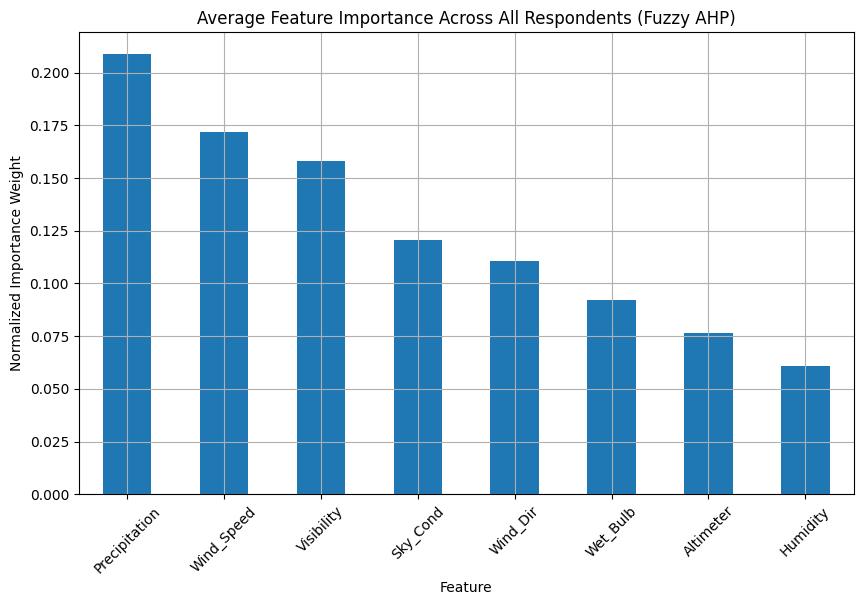

In [ ]:
import matplotlib.pyplot as plt

# ✅ Average feature importance
average_weights = priority_df.mean().sort_values(ascending=False)

# ✅ Bar Plot
plt.figure(figsize=(10,6))
average_weights.plot(kind='bar')
plt.title("Average Feature Importance Across All Respondents (Fuzzy AHP)")
plt.ylabel("Normalized Importance Weight")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


No individual comparison's required since this is a fuzzy evaluation. Moved directly to PCA.

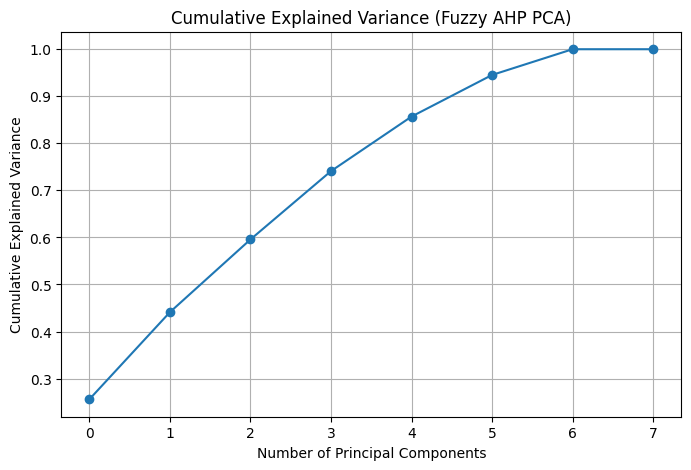

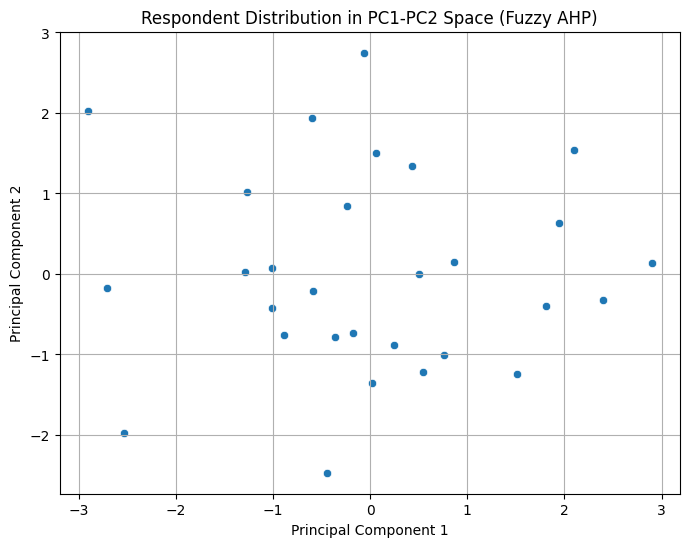

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Step 1: Standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(priority_df)

# ✅ Step 2: Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# ✅ Step 3: Scree Plot (explained variance)
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance (Fuzzy AHP PCA)')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# ✅ Step 4: 2D Scatter Plot (first 2 principal components)
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1])
plt.title('Respondent Distribution in PC1-PC2 Space (Fuzzy AHP)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [ ]:
# ✅ Explained Variance Ratios
explained_variance = pca.explained_variance_ratio_

# ✅ Print it cleanly
print("\nExplained Variance Ratio by Component:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f}")



Explained Variance Ratio by Component:
PC1: 0.2561
PC2: 0.1851
PC3: 0.1545
PC4: 0.1452
PC5: 0.1159
PC6: 0.0884
PC7: 0.0547
PC8: 0.0000


In [ ]:
# ✅ PCA Loadings: Feature-to-Component relationships
loadings = pd.DataFrame(
    pca.components_.T,
    index=priority_df.columns,
    columns=[f'PC{i+1}' for i in range(len(priority_df.columns))]
)

print("\nPCA Feature Loadings:")
print(loadings.round(4))




PCA Feature Loadings:
                  PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8
Wet_Bulb      -0.4178  0.0587  0.5124  0.3072 -0.2609  0.2621 -0.4571  0.3456
Altimeter      0.0385  0.6338 -0.3009 -0.3345  0.1932 -0.1593 -0.4958  0.2931
Precipitation -0.4036 -0.4031 -0.3287 -0.4185 -0.2744 -0.0925  0.1700  0.5279
Humidity      -0.4147  0.4249  0.0213  0.2319  0.4022  0.0851  0.6084  0.2325
Sky_Cond       0.2899  0.2096 -0.2014  0.5269 -0.5214 -0.4247  0.1551  0.2785
Visibility     0.1148 -0.4356 -0.3080  0.4655  0.5595  0.0046 -0.2740  0.3122
Wind_Dir       0.5443  0.0705 -0.0015 -0.1176 -0.0946  0.7001  0.1818  0.3909
Wind_Speed     0.3092 -0.1147  0.6348 -0.2383  0.2524 -0.4686  0.1183  0.3663


In [ ]:
loadings.to_csv("Fuzzy_AHP_PCA_Loadings.csv")
from google.colab import files
files.download("Fuzzy_AHP_PCA_Loadings.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

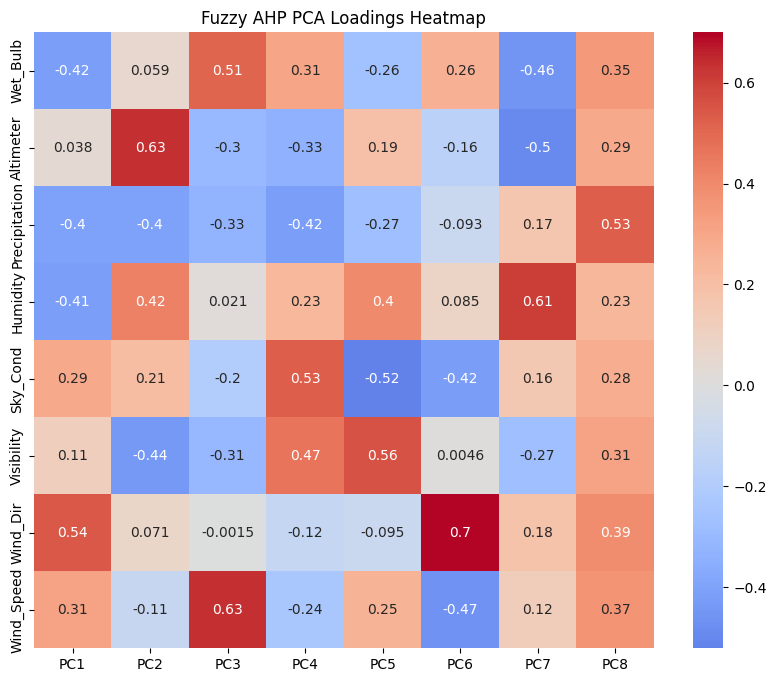

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(loadings, annot=True, cmap="coolwarm", center=0)
plt.title("Fuzzy AHP PCA Loadings Heatmap")
plt.show()
plt.savefig("PCA_Loadings_Heatmap_Fuzzy_AHP.png", dpi=300)

# ✅ Download heatmap
files.download("PCA_Loadings_Heatmap_Fuzzy_AHP.png")

In [ ]:
from scipy.stats import spearmanr

ahp_ranks = [1, 2, 3, 4, 5, 6, 7, 8]
fuzzy_ranks = [1, 2, 3, 5, 4, 6, 7, 8]  # Based on your rank switch

corr, p = spearmanr(ahp_ranks, fuzzy_ranks)
print(f"Spearman Correlation: {corr:.4f}, p-value: {p:.4f}")


Spearman Correlation: 0.9762, p-value: 0.0000
